In [1]:
import os
import numpy as np
import time
import copy
import sys
import matplotlib.pyplot as plt

ang_2_bohr = 1.0/0.52917721067


import molog_loading_utils as mlu

In [2]:
folder = "/home/kristjan/sshfs/daint_scratch/cp2k_cnt_orbitals/"

file_basis_set = folder + "BR"


file_xyz = folder + "c2h2_rot/p.xyz"

file_molog = folder + "c2h2_rot/morb/PROJ-COEFF-1_0.MOLog"

file_cp2k_inp = folder + "c2h2_rot/morb/cp2k.inp"

In [3]:
height = 3.5 # Plane distance in z direction from topmost atom; angstroms

emax =  100 # eV
emin = -100 # eV

In [4]:
elem_basis_names, cell, cell_n = mlu.read_cp2k_input(file_cp2k_inp)

at_positions, at_elems = mlu.read_atoms(file_xyz)

basis_sets = mlu.read_basis_functions(file_basis_set, elem_basis_names)

morb_composition, morb_energies = mlu.read_and_process_molog(file_molog)

Reading CP2K MOs from:/home/kristjan/sshfs/daint_scratch/cp2k_cnt_orbitals/c2h2_rot/morb/PROJ-COEFF-1_0.MOLog
Found 10 MOs spanned by 38 basis functions centered on 4 atoms.


In [5]:
def spherical_harmonic_grid(l, m, x_grid, y_grid, z_grid):
    c = (2.0/np.pi)**(3.0/4.0)
    
    # s orbitals
    if (l, m) == (0, 0):
        return c
    
    # p orbitals
    elif (l, m) == (1, -1):
        return c*2.0*y_grid
    elif (l, m) == (1, 0):
        return c*2.0*z_grid
    elif (l, m) == (1, 1):
        return c*2.0*x_grid
    
    # d orbitals
    elif (l, m) == (2, -2):
        return c*4.0*x_grid*y_grid
    elif (l, m) == (2, -1):
        return c*4.0*y_grid*z_grid
    elif (l, m) == (2, 0):
        return c*2.0/np.sqrt(3)*(2*z_grid**2-x_grid**2-y_grid**2)
    elif (l, m) == (2, 1):
        return c*4.0*z_grid*x_grid
    elif (l, m) == (2, 2):
        return c*2.0*(x_grid**2-y_grid**2)
    
    print("No spherical harmonic found for l=%d, m=%d" % (l, m))
    return 0


def add_local_to_global_grid(loc_grid, glob_grid, origin_diff):
    loc_nx, loc_ny = np.shape(loc_grid)
    glob_nx, glob_ny = np.shape(glob_grid)
    od = origin_diff
    
    if loc_nx <= glob_nx and loc_ny <= glob_ny:
        ix_arr = (np.arange(loc_nx) + od[0]) % glob_nx
        iy_arr = (np.arange(loc_ny) + od[1]) % glob_ny
        ix_grid, iy_grid = np.meshgrid(ix_arr, iy_arr, indexing='ij')
        glob_grid[ix_grid, iy_grid] += loc_grid
    else:
        n_x_arr = np.ceil(loc_nx/glob_nx)
        n_y_arr = np.ceil(loc_ny/glob_ny)
        
        ix_is = np.array_split(np.arange(loc_nx), n_x_arr)
        iy_is = np.array_split(np.arange(loc_ny), n_y_arr)
        
        for ix_i in ix_is:
            for iy_i in iy_is:
                ix_i_grid, iy_i_grid = np.meshgrid(ix_i, iy_i, indexing='ij')
                ix_a_grid = (ix_i_grid + od[0]) % glob_nx
                iy_a_grid = (iy_i_grid + od[1]) % glob_ny
                glob_grid[ix_a_grid, iy_a_grid] += loc_grid[ix_i_grid, iy_i_grid]
                
#loc_grid = np.ones((7, 7))
#glob_grid = np.zeros((5, 5))
#origin_diff = np.array([-1, -1])
#
#add_local_to_global_grid(loc_grid, glob_grid, origin_diff)
#glob_grid        

In [6]:
# Sort out molecular orbitals in the specified energy range
sel_morb_composition = []
sel_morb_energies = []
for i_mo, morb in enumerate(morb_composition):
    energy = morb_energies[i_mo]
    if energy > emin and energy < emax:
        sel_morb_energies.append(energy)
        sel_morb_composition.append(morb)

In [7]:
# Define the plane

start_time = time.time()

plane_z = np.max(at_positions[:, 2]) + height

# Use similar grid spacing to cp2k cube files
dv = cell[0:2]/cell_n[0:2]
x_arr = np.arange(0, cell[0], dv[0])
y_arr = np.arange(0, cell[1], dv[1])
x_grid, y_grid = np.meshgrid(x_arr, y_arr, indexing='ij')

# Define small grid for orbital evaluation
# and convenient PBC implementation
loc_cell = np.array([8.0,  8.0])*ang_2_bohr
x_arr_loc = np.arange(0, loc_cell[0], dv[0])
y_arr_loc = np.arange(0, loc_cell[1], dv[1])
loc_cell_n = np.array([len(x_arr_loc), len(y_arr_loc)])
# Define it such that the origin is somewhere
# in the middle but exactly on a grid point
mid_ixs = (loc_cell_n/2).astype(int)
x_arr_loc -= x_arr_loc[mid_ixs[0]]
y_arr_loc -= y_arr_loc[mid_ixs[1]]
x_grid_loc, y_grid_loc = np.meshgrid(x_arr_loc, y_arr_loc, indexing='ij')

# Some info
print("Main cell:   ", cell, cell_n)
print("Local plane: ", loc_cell, loc_cell_n)


morb_planes = [np.zeros(cell_n[0:2]) for _ in range(len(sel_morb_composition))]

aorbs = []

for i_at in range(len(at_positions)):
        elem = at_elems[i_at][0]
        pos = at_positions[i_at]
        
        # how does the position match with the grid?
        int_shift = (pos[0:2]/dv).astype(int)
        frac_shift = pos[0:2]/dv - int_shift
        
        # Shift the local grid such that origin is on the atom
        x_grid_rel_loc = x_grid_loc - frac_shift[0]*dv[0]
        y_grid_rel_loc = y_grid_loc - frac_shift[1]*dv[1]
        
        z_rel = plane_z - pos[2]
        
        r_vec_2 = x_grid_rel_loc**2 + y_grid_rel_loc**2 + z_rel**2
        
        for i_shell, shell in enumerate(basis_sets[elem]):
            l = shell[0]
            es = shell[1]
            cs = shell[2]
            
            # Calculate the radial part of the atomic orbital
            radial_part = np.zeros(loc_cell_n)
            for e, c in zip(es, cs):
                radial_part += c*np.exp(-1.0*e*r_vec_2)
            
            for i, m in enumerate(range(-l, l+1, 1)):
                atomic_orb = radial_part*spherical_harmonic_grid(l, m,
                                                                 x_grid_rel_loc,
                                                                 y_grid_rel_loc,
                                                                 z_rel)
                aorbs.append(atomic_orb)
                
                for i_mo in range(len(sel_morb_composition)):
                    coef = sel_morb_composition[i_mo][i_at][i_shell][i]

                    # Add the atomic orbital on the local grid to the global grid
                    origin_diff = int_shift - mid_ixs
                    add_local_to_global_grid(coef*atomic_orb, morb_planes[i_mo], origin_diff)
            
            
print("time: %f"%(time.time() - start_time))                 

Main cell:    [ 15.117809    15.117809    28.34589188] [100 100 188]
Local plane:  [ 15.117809  15.117809] [100 100]
time: 0.090389


In [8]:
# Define the plane

start_time = time.time()

plane_z = np.max(at_positions[:, 2]) + height

# Use similar grid spacing to cp2k cube files
dv = cell[0:2]/cell_n[0:2]
x_arr = np.arange(0, cell[0], dv[0])
y_arr = np.arange(0, cell[1], dv[1])
x_grid, y_grid = np.meshgrid(x_arr, y_arr, indexing='ij')

morb_planes_nopbc = [np.zeros(cell_n[0:2]) for _ in range(len(sel_morb_composition))]

aorbs_nopbc = []

for i_at in range(len(at_positions)):
        elem = at_elems[i_at][0]
        pos = at_positions[i_at]
        
        # Shift the local grid such that origin is on the atom
        x_grid_rel = x_grid - pos[0]
        y_grid_rel = y_grid - pos[1]
        
        z_rel = plane_z - pos[2]
        
        r_vec_2 = x_grid_rel**2 + y_grid_rel**2 + z_rel**2
        
        for i_shell, shell in enumerate(basis_sets[elem]):
            l = shell[0]
            es = shell[1]
            cs = shell[2]
            
            # Calculate the radial part of the atomic orbital
            radial_part = np.zeros(cell_n[0:2])
            for e, c in zip(es, cs):
                radial_part += c*np.exp(-1.0*e*r_vec_2)
            
            for i, m in enumerate(range(-l, l+1, 1)):
                atomic_orb = radial_part*spherical_harmonic_grid(l, m,
                                                                 x_grid_rel,
                                                                 y_grid_rel,
                                                                 z_rel)
                aorbs_nopbc.append(atomic_orb)
                
                for i_mo in range(len(sel_morb_composition)):
                    coef = sel_morb_composition[i_mo][i_at][i_shell][i]
                    morb_planes_nopbc[i_mo] += coef*atomic_orb
                    
            
print("time: %f"%(time.time() - start_time))                 

time: 0.033506


-14.7647659174


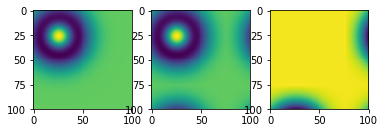

-10.3657963191


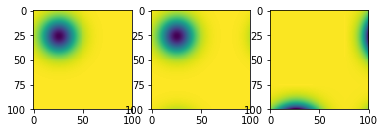

-8.42311684932


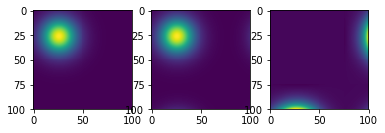

-3.3906241534


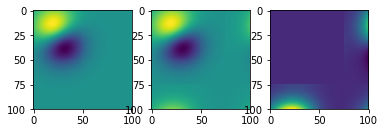

-3.37823493005


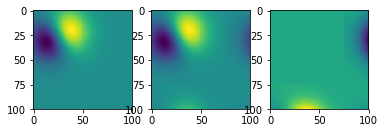

3.37823493005


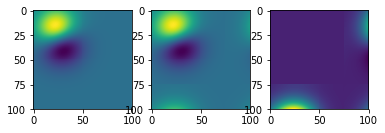

3.4782995501


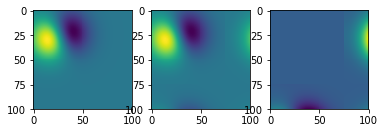

6.34811040304


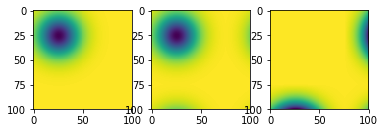

7.66685638109


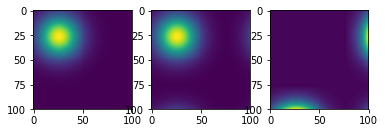

13.7230975903


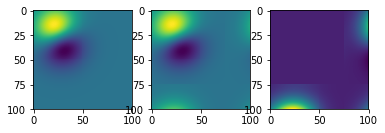

In [10]:
for i in range(len(morb_planes)):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    print(morb_energies[i])
    ax1.imshow(morb_planes_nopbc[i])
    ax2.imshow(morb_planes[i])
    ax3.imshow(morb_planes[i]-morb_planes_nopbc[i])
    plt.show()

In [ ]:
def write_cube_file(filename, file_xyz, cell, cell_n, data):
    
    # Read atomic positions (a.u.)
    positions, elems_nrs = read_atoms(file_xyz)
    
    natoms = len(positions)
    origin = np.array([0.0, 0.0, 0.0])
    origin *= ang_2_bohr
    
    f = open(filename, 'w')
    
    f.write('title\n')
    f.write('comment\n')
    
    dv_br = cell/cell_n
    dv_br = dv_br * np.diag([1, 1, 1])
    
    f.write("%5d %12.6f %12.6f %12.6f\n"%(natoms, origin[0], origin[1], origin[2]))
    
    for i in range(3):
        f.write("%5d %12.6f %12.6f %12.6f\n"%(cell_n[i], dv_br[i][0], dv_br[i][1], dv_br[i][2]))
    
    for i in range(natoms):
        at_x = positions[i][0]
        at_y = positions[i][1]
        at_z = positions[i][2]
        f.write("%5d %12.6f %12.6f %12.6f %12.6f\n"%(elems_nrs[i][1], 0.0, at_x, at_y, at_z))
    
    data.tofile(f, sep='\n', format='%12.6e')
    
    f.close()
    